In [1]:
import xarray as xr
import pathlib
from pathlib import Path
import numpy as np
# import pyvista as pv
import matplotlib.pyplot as plt
import h5netcdf
import h5py

In [2]:
xr.__version__

'0.18.0'

In [3]:
# make your root_dir the current working directory
root_dir = Path.cwd() # set the root directory as a Pathlib path

folder_raw_data = root_dir / 'data/raw/' # raw data folder that holds the .zip .mat files for milling data

# make processed data directory if doesn't exist already
Path(root_dir / 'data/processed/').mkdir(parents=True, exist_ok=True)
folder_processed_data = root_dir / 'data/processed/'

In [4]:
data = xr.open_dataset(folder_raw_data / 'spherical001.nc',)
data                      # show all variables inside this dataset

<xarray.Dataset>
Dimensions:                                  (lat: 180, lon: 360, r: 201)
Coordinates:
  * lon                                      (lon) float64 0.0 1.003 ... 360.0
  * r                                        (r) float64 3.485e+03 ... 6.371e+03
  * lat                                      (lat) float64 90.0 89.49 ... -90.0
Data variables:
    temperature                              (lat, r, lon) float32 ...
    vx                                       (lat, r, lon) float32 ...
    vy                                       (lat, r, lon) float32 ...
    vz                                       (lat, r, lon) float32 ...
    thermal conductivity                     (lat, r, lon) float32 ...
    thermal expansivity                      (lat, r, lon) float32 ...
    temperature anomaly                      (lat, r, lon) float32 ...
    spin transition-induced density anomaly  (lat, r, lon) float32 ...

Let's look at how each data variable and coordinate is structured.

In [5]:
for c in list(data.coords):
    print(f'{c} shape:\t',np.shape(data[c]))

lon shape:	 (360,)
r shape:	 (201,)
lat shape:	 (180,)


In [6]:
for v in list(data.keys()):
    max_val = np.max(data[v].values)
    min_val =  np.min(data[v].values)
    shape_val = np.shape(data[v])
    print(f'{v:45} shape: {str(shape_val):} \tmax: {str(max_val):10s} \tmin: {min_val}' )

temperature                                   shape: (180, 201, 360) 	max: 3607.3438  	min: 293.0
vx                                            shape: (180, 201, 360) 	max: 5.700776e-09 	min: -3.9670631224453246e-09
vy                                            shape: (180, 201, 360) 	max: 5.82114e-09 	min: -4.824658006441496e-09
vz                                            shape: (180, 201, 360) 	max: 7.457673e-09 	min: -5.615409026660245e-09
thermal conductivity                          shape: (180, 201, 360) 	max: 0.5701583  	min: -0.7660495042800903
thermal expansivity                           shape: (180, 201, 360) 	max: 8.694364e-07 	min: -2.170390416722512e-06
temperature anomaly                           shape: (180, 201, 360) 	max: 1105.4534  	min: -1099.197509765625
spin transition-induced density anomaly       shape: (180, 201, 360) 	max: 130.17787  	min: -166.5840301513672


## Test Different Data Types
Most of the data is stored as a numpy `float32`. The data file, `spherical001.nc` is 417 MB. Thus, I'm curious to see how much "storage" we can save by converting to single precision.

In [7]:
# double precision
a = np.array([0.123456789123456789], dtype='float64')
print(a.dtype)
print(a[0])

float64
0.12345678912345678


In [8]:
# single precision
a = np.array([0.123456789123456789], dtype='float32')
print(a.dtype)
print(a[0])

float32
0.12345679


In [9]:
# half precision
a = np.array([0.123456789123456789], dtype='float16')
print(a.dtype)
print(a[0])

float16
0.1235


You can change the dtype to 'float16' via the following:

In [10]:
enc_var = {}
# create list of encodings

for v in list(data.keys()):
    enc_var[v] = {'dtype':'float16'}

# save data with the 'float16' variables
# data.to_netcdf("saved_on_disk.nc", encoding=enc_var, engine='h5netcdf')

# load the data back
data2 = xr.open_dataset('saved_on_disk.nc',engine='h5netcdf')
data2

<xarray.Dataset>
Dimensions:                                  (lat: 180, lon: 360, r: 201)
Coordinates:
  * lat                                      (lat) float64 90.0 89.49 ... -90.0
  * lon                                      (lon) float64 0.0 1.003 ... 360.0
  * r                                        (r) float64 3.485e+03 ... 6.371e+03
Data variables:
    spin transition-induced density anomaly  (lat, r, lon) float16 ...
    temperature                              (lat, r, lon) float16 ...
    temperature anomaly                      (lat, r, lon) float16 ...
    thermal conductivity                     (lat, r, lon) float16 ...
    thermal expansivity                      (lat, r, lon) float16 ...
    vx                                       (lat, r, lon) float16 ...
    vy                                       (lat, r, lon) float16 ...
    vz                                       (lat, r, lon) float16 ...

The new data set, half-precision, is 208 MB in size.

## Plot Some Variables
Start with plotting the normal `float32` data.

In [15]:
np.max(data[list(data.keys())[0]].values[:,16,:])

3363.6465

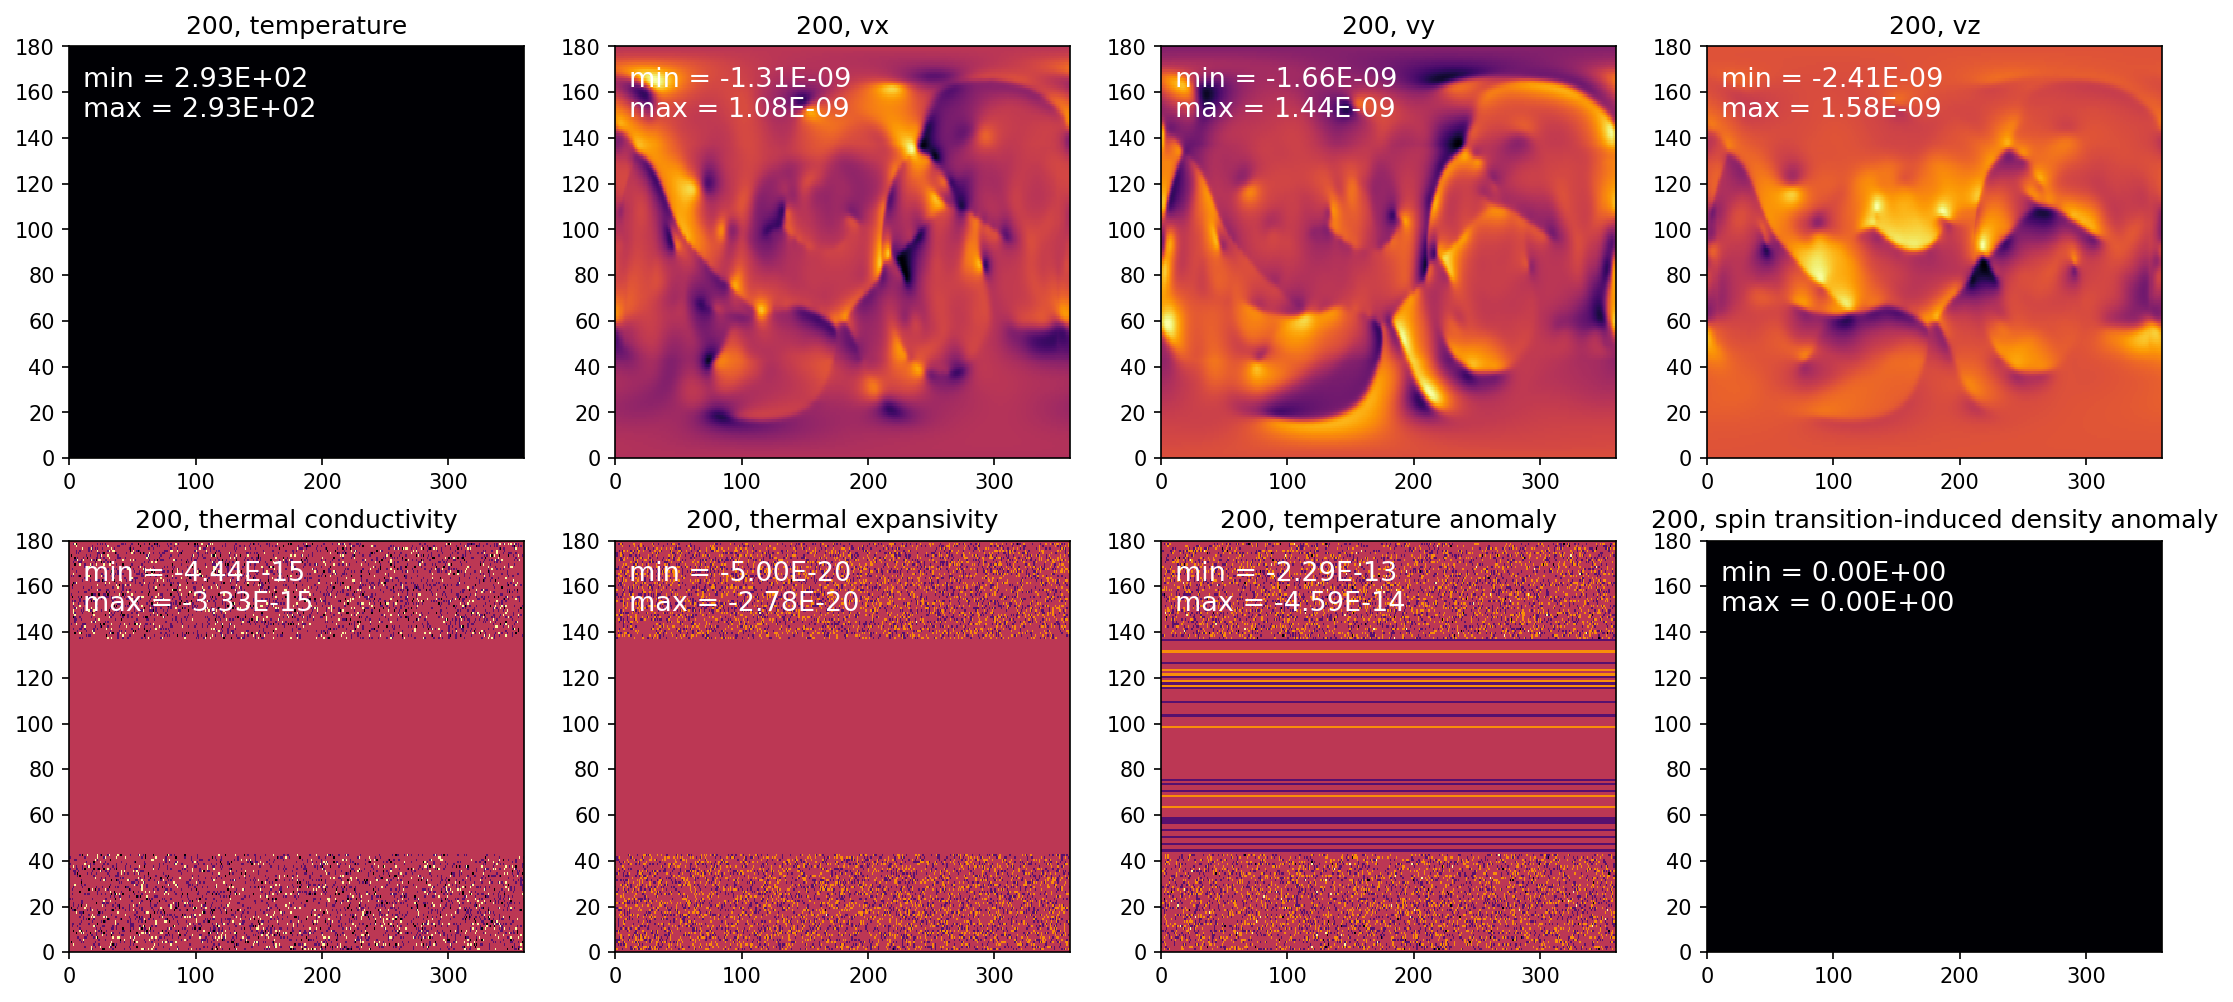

In [22]:
r_index = 200 # between 0 and 200
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8), dpi=150)
color_scheme='inferno'

for variable, ax in zip(list(data.keys()), axes.flat):
    ax.pcolormesh(data[variable].values[:,r_index,:], cmap=color_scheme)
    ax.set_title(f"{r_index}, {variable}")
    min_val = np.min(data[variable].values[:,r_index,:])
    max_val = np.max(data[variable].values[:,r_index,:])
    
    
    
    print_text = f"min = {min_val:.2E}\nmax = {max_val:.2E}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=13,
        fontweight="normal",
        verticalalignment="top",
        color='white',
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

plt.show()

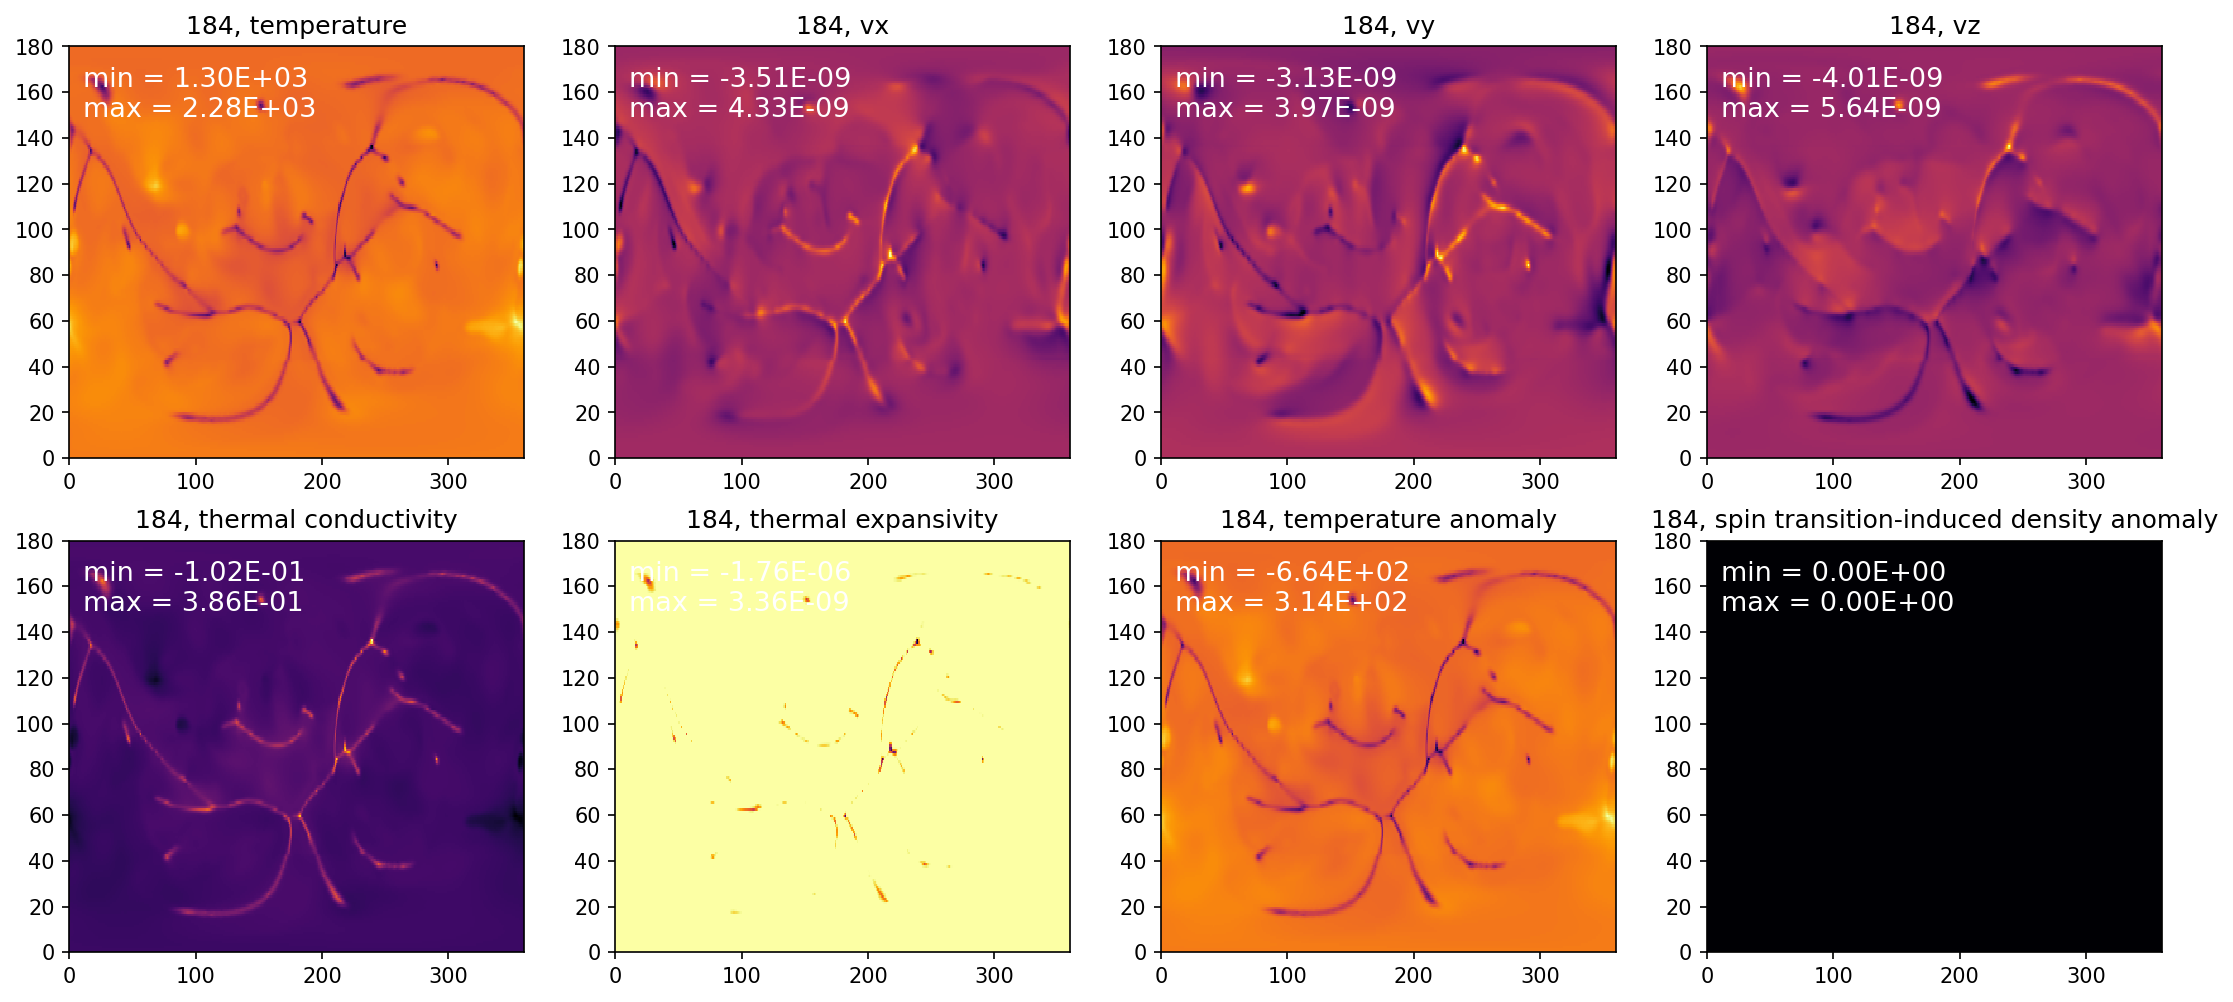

In [23]:
r_index = 184 # between 0 and 200
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8), dpi=150)
color_scheme='inferno'

for variable, ax in zip(list(data.keys()), axes.flat):
    ax.pcolormesh(data[variable].values[:,r_index,:], cmap=color_scheme)
    ax.set_title(f"{r_index}, {variable}")
    min_val = np.min(data[variable].values[:,r_index,:])
    max_val = np.max(data[variable].values[:,r_index,:])
    
    
    
    print_text = f"min = {min_val:.2E}\nmax = {max_val:.2E}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=13,
        fontweight="normal",
        verticalalignment="top",
        color='white',
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

plt.show()

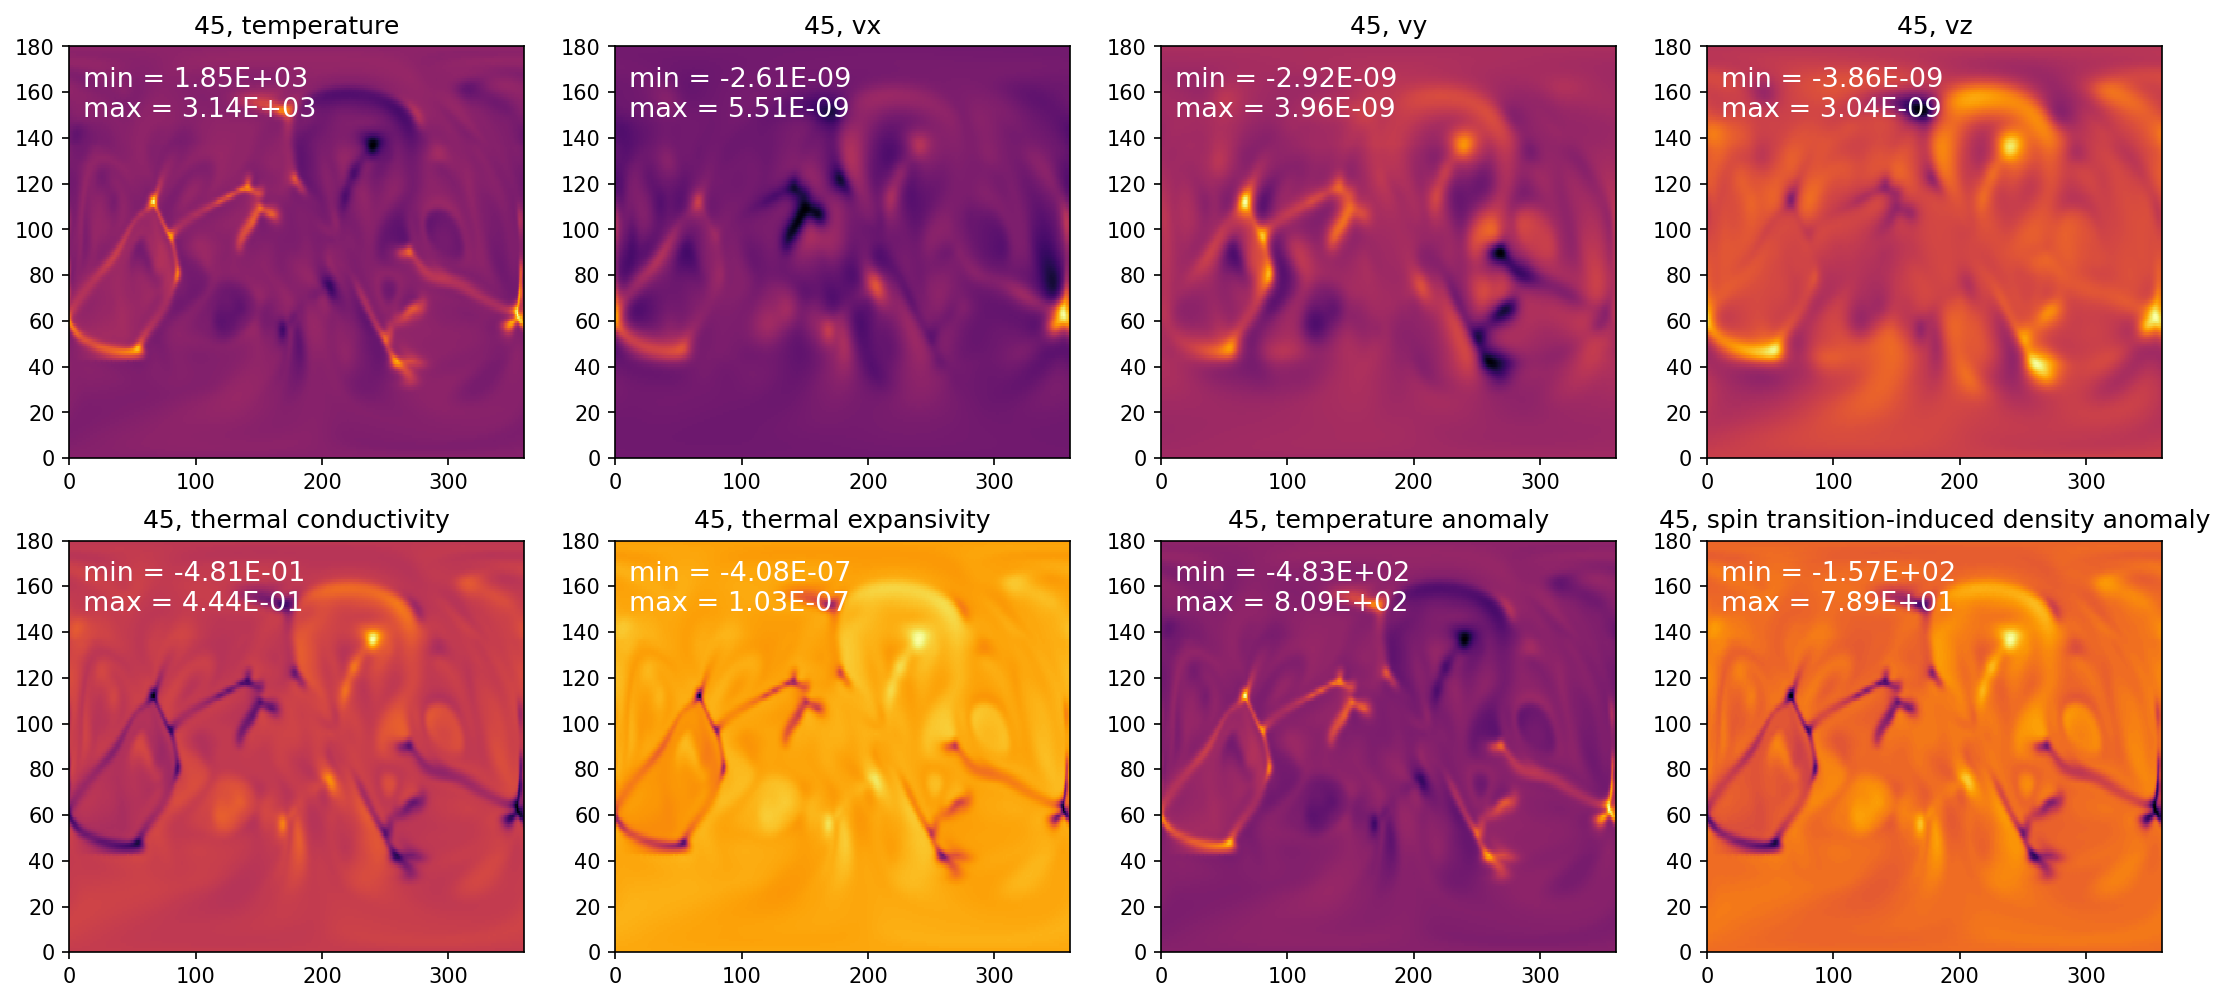

In [24]:
r_index = 45 # between 0 and 200
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8), dpi=150)
color_scheme='inferno'

for variable, ax in zip(list(data.keys()), axes.flat):
    ax.pcolormesh(data[variable].values[:,r_index,:], cmap=color_scheme)
    ax.set_title(f"{r_index}, {variable}")
    min_val = np.min(data[variable].values[:,r_index,:])
    max_val = np.max(data[variable].values[:,r_index,:])
    
    
    
    print_text = f"min = {min_val:.2E}\nmax = {max_val:.2E}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=13,
        fontweight="normal",
        verticalalignment="top",
        color='white',
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

plt.show()

Save a copy of all the radial slices so that we can inspect them for outliers/weired things.

The below will take a decent amount of time to run...

In [43]:
# make folder to save images if not already created
img_folder = Path('img_all_slices')
pathlib.Path(img_folder).mkdir(parents=True, exist_ok=True)

# iterate through each of the 200 radial layers of the earth mantle data set
for r_index in range(201):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8),)
    color_scheme='inferno'

    for variable, ax in zip(list(data.keys()), axes.flat):
        ax.pcolormesh(data[variable].values[:,r_index,:], cmap=color_scheme)
        ax.set_title(f"{r_index}, {variable}")
        min_val = np.min(data[variable].values[:,r_index,:])
        max_val = np.max(data[variable].values[:,r_index,:])



        print_text = f"min = {min_val:.2E}\nmax = {max_val:.2E}"

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        ax.text(
            (x_max - x_min) * 0.03 + x_min,
            y_max - (y_max - y_min) * 0.05,
            print_text,
            fontsize=13,
            fontweight="normal",
            verticalalignment="top",
            color='white',
            horizontalalignment="left",
            bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
        )
        
        save_name = img_folder / f'r_index_{r_index}.jpg'
        
    plt.savefig(save_name, bbox_inches = "tight")
    plt.close('all')

Clearly, the first (`r_index = 0`) and last (`r_index = 200`) radial slices contain "corrupt" data. Need to discard these.

Plot the `float16` data.

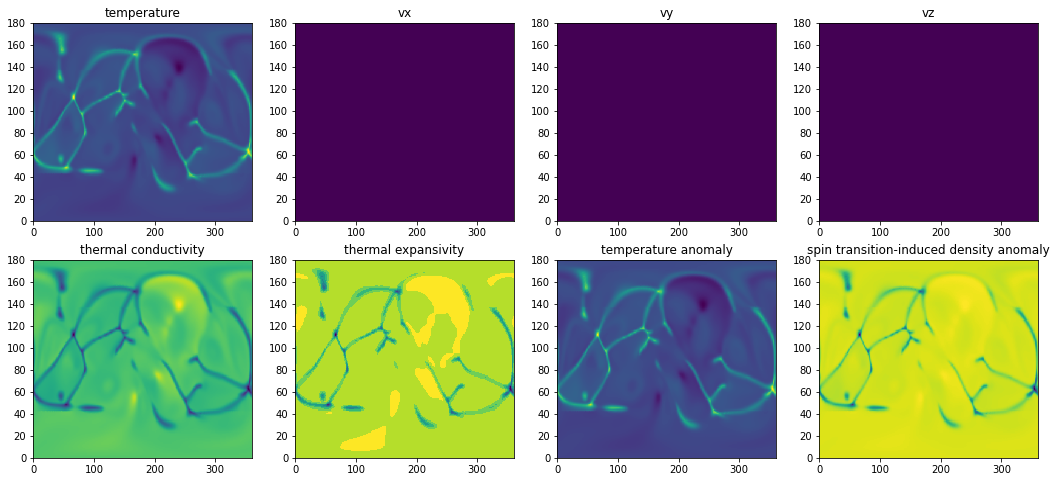

In [12]:
r_index = 16
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))

for variable, ax in zip(list(data.keys()), axes.flat):
    ax.pcolormesh(data2[variable].values[:,r_index,:])
    ax.set_title(variable)

plt.show()

Ok, moving the data to `float16` really washes out any definition. I'm guessing this is likely due to the small values in some of the variables. Let's compare some of the different half-precision and single-precision data points.

In [13]:
data['vy'].values[:,16,:][:,0][:10]

array([ 7.1652628e-11,  6.4325816e-11,  4.8967629e-11,  3.2271397e-11,
        1.4361548e-11, -4.5334136e-12, -2.4152111e-11, -4.4206309e-11,
       -6.4305977e-11, -8.4084975e-11], dtype=float32)

In [14]:
data2['vy'].values[:,16,:][:,0][:10]

array([ 0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.], dtype=float16)

Yup, as expected.

## Rotate Data about North-South Axis
We can "roll" the maps about the North-South axis. This will be useful for data augmentation. We can use numpy's rollaxis to do this. Let's practice.

shape a: (180, 360)


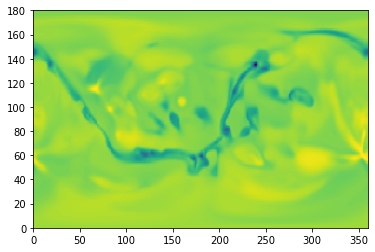

In [15]:
r_index = 145
a = data['thermal expansivity'].values[:,r_index,:]
print('shape a:', a.shape)
plt.pcolormesh(a)
plt.show()

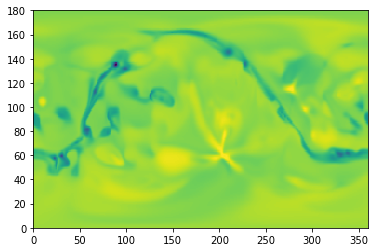

In [16]:
plt.pcolormesh(np.roll(a, -150, axis=1))
plt.show()

## Pad Data at Edges
We will pad the data at the edges with a few extra columns. This will be useful when we are moving CNN filters over the data, as we want it to learn relationships over at the edges of the data.

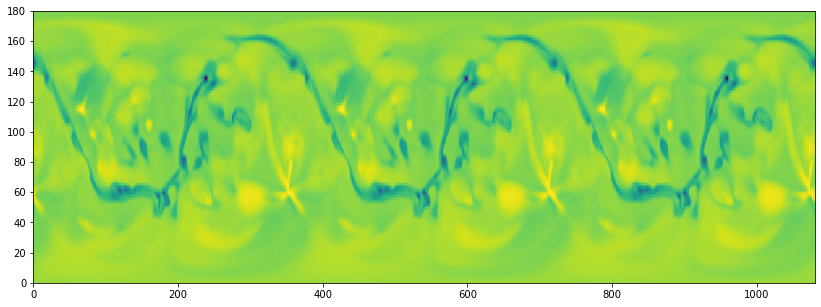

In [17]:
# we can concatenate 3 of the maps together
fig, ax = plt.subplots(1,1, figsize=(14,5))
plt.pcolormesh(np.concatenate((a, a, a),axis=1))
plt.show()

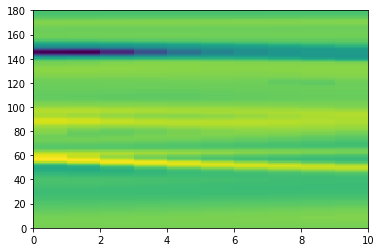

In [18]:
# take the first 10 columns in the map
plt.pcolormesh(a[:,:10])

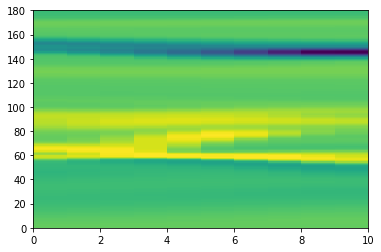

In [19]:
# take the last 10 columns in the map
plt.pcolormesh(a[:,-10:])

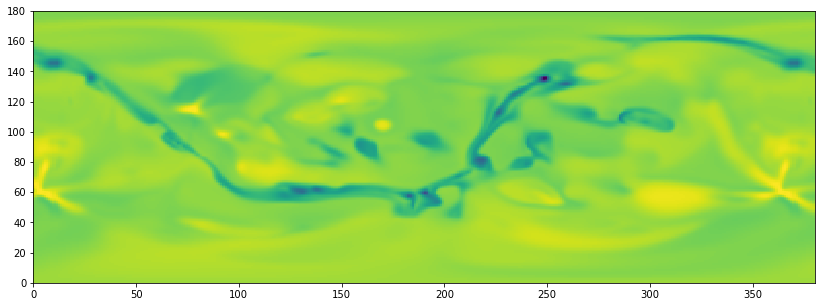

In [20]:
# concatenate the last 10 onto the front
# concatenate the first 10 onto the end
fig, ax = plt.subplots(1,1, figsize=(14,5))
plt.pcolormesh(np.concatenate((a[:,-10:], a, a[:,:10] ),axis=1))
plt.show()

## Downsample Data
We will need to downsample the data, significantly, so that we can prototype some neural networks.

In [21]:
import cv2

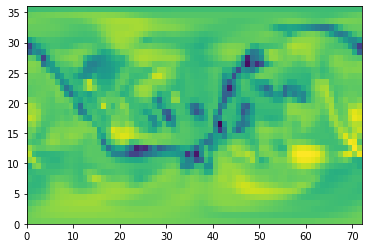

In [22]:
# a shape: (180, 360)
scale_percent = 20 # percent of original size
width = int(a.shape[1] * scale_percent / 100)
height = int(a.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(a, dim, interpolation = cv2.INTER_AREA)

plt.pcolormesh(resized)
plt.show()

In [23]:
print('Original shape:\t', a.shape)
print('New shape:\t', resized.shape)

Original shape:	 (180, 360)
New shape:	 (36, 72)


## Downsample All Data and Save
We'll now downsample all the data and save it as a pickle. 

In [24]:
# create a list of all the variables.
var_list = list(data.keys())
print(var_list)

['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


In [25]:
# stack all the variables together, about the last dimension
data_array = np.stack([data[var_name].values for var_name in var_list], axis=-1)

# check shape of data_array
print('shape data_array:', np.shape(data_array))

shape data_array: (180, 201, 360, 8)


The `data_array` has a shape of `(180, 201, 360, 8)`, which is equivalent to `(latitude, radius, longitude, variable)`. Thinking about the array in terms of computer vision, the `variable` is like the RGB channel in color images.

To make sure we're sane, let's get the same image from our example above. Here's the example:

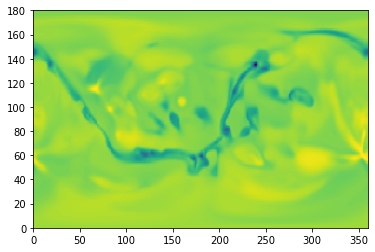

In [26]:
r_index = 145
a = data['thermal expansivity'].values[:,r_index,:]
plt.pcolormesh(a)
plt.show()

We'll create a fast script to quickly select the proper map based on the radius index, `r_index`, and the variable name (like 'thermal expansivity').

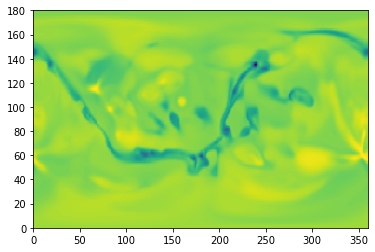

Images are the same


In [27]:
r_index = 145
var_to_plot = 'thermal expansivity'

for i, var_name in enumerate(var_list):
    if var_name == var_to_plot:
        temp_array = data_array[:,r_index,:,i]

plt.pcolormesh(temp_array)
plt.show()

if np.array_equal(a, temp_array):
    print('Images are the same')
else:
    print('Images are NOT the same!')

It works! The two maps, above, are the same.

Now let's scale the entire array.

In [28]:
scale_percent = 25 # percent of original size
width = int(360 * scale_percent / 100)
height = int(180 * scale_percent / 100)
dim = (width, height)

data_scaled_list = []
for i, var_name in enumerate(var_list):
    temp_list = []
    b = data[var_name].values
    for radius_index in range(b.shape[1]):
        temp_list.append(cv2.resize(b[:,radius_index,:], dim, interpolation=cv2.INTER_AREA))

    temp_array = np.stack(temp_list, axis=1)
    data_scaled_list.append(temp_array)

data_scaled_array = np.stack(data_scaled_list, axis=-1)
print('shape data_scaled_array:', data_scaled_array.shape)

shape data_scaled_array: (45, 201, 90, 8)


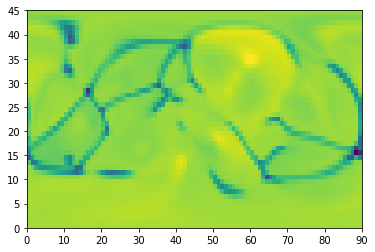

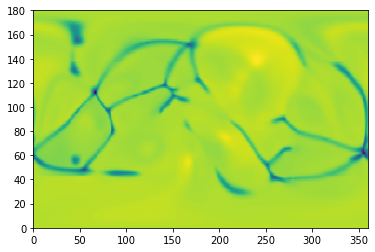

In [29]:
r_index = 16
var_to_plot = 'thermal expansivity'

for i, var_name in enumerate(var_list):
    if var_name == var_to_plot:
        temp_array = data_scaled_array[:,r_index,:,i]

plt.pcolormesh(temp_array)
plt.show()
plt.pcolormesh(data[var_to_plot][:,r_index,:])
plt.show()

I think the two maps, above, make sense.

Now we'll save the array as an hdf5 file.

In [30]:
with h5py.File(folder_processed_data / "x_001.hdf5", "w") as f:
    dset = f.create_dataset("x_001", data=data_scaled_array)

In [31]:
# load data
with h5py.File(folder_processed_data / "x_001.hdf5", "r") as f:
    data_scaled = f["x_001"][:]
    
print('shape data_scaled:', data_scaled.shape)

shape data_scaled: (45, 201, 90, 8)


## Linear Interpolation for Upscaling
In the paper "AI-assisted superresolution cosmological simulations", they use linear interpolation upscaling in between convolulutions.

In [32]:
# downscale
orig_scale_percent = 0.5 # percent of original size
width = int(360 * orig_scale_percent)
height = int(180 * orig_scale_percent)
dim = (width, height)

data_scaled_list = []
for i, var_name in enumerate(var_list):
    temp_list = []
    b = data[var_name].values.copy()
    for radius_index in range(b.shape[1]):
        temp_list.append(cv2.resize(b[:,radius_index,:], dim, interpolation=cv2.INTER_AREA))

    temp_array = np.stack(temp_list, axis=1)
    data_scaled_list.append(temp_array)

data_scaled_array = np.stack(data_scaled_list, axis=-1)
print('shape data_scaled_array:', data_scaled_array.shape)

# upscale data
# use INTER_LINEAR
scale_percent = 180/data_scaled_array.shape[0] # percent of original size
width = int(data_scaled_array.shape[2] * scale_percent)
height = int(data_scaled_array.shape[0] * scale_percent)
dim = (width, height)

data_scaled_list = []
for i, var_name in enumerate(var_list):
    temp_list = []
    b = data_scaled_array[:,:,:,i].copy()
    for radius_index in range(b.shape[1]):
        temp_list.append(cv2.resize(b[:,radius_index,:], dim, interpolation=cv2.INTER_CUBIC))

    temp_array = np.stack(temp_list, axis=1)
    data_scaled_list.append(temp_array)

data_upscaled_array = np.stack(data_scaled_list, axis=-1)
print('shape data_upscaled_array:', data_upscaled_array.shape)

print(var_list)

shape data_scaled_array: (90, 201, 180, 8)
shape data_upscaled_array: (180, 201, 360, 8)
['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


temperature


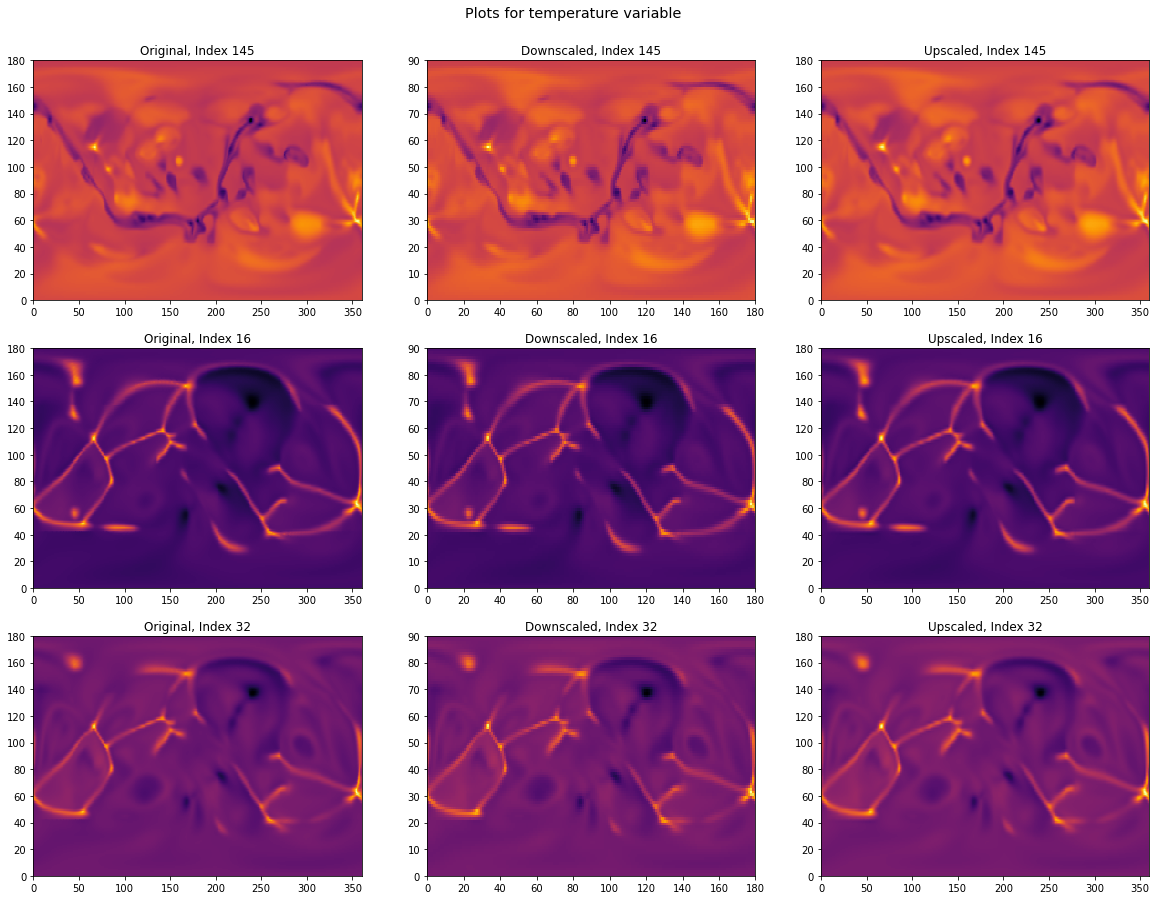

In [33]:
var_to_plot = var_list[0]
print(var_to_plot)
color_scheme='inferno'

        
title_list = ['Original', "Downscaled", "Upscaled"]*3
r_index_list = np.array([145, 16 ,32]*3).reshape((3,3)).flatten('F') # flatten array

# create image
fig, axes = plt.subplots(3,3, figsize=(20,15))

for ax, title, r_index in zip(axes.flat, title_list, r_index_list):
    
    # original data
    if title == 'Original':

        orig_data = data[var_to_plot][:,r_index,:].values.copy()
        ax.pcolormesh(orig_data, cmap=color_scheme)
        ax.set_title(f"{title}, Index {r_index}")
    
    # downscaled data
    if title == 'Downscaled':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                downscale_data = data_scaled_array[:,r_index,:,i]
                ax.pcolormesh(downscale_data, cmap=color_scheme)
                ax.set_title(f"{title}, Index {r_index}")


    # upscale data
    if title == 'Upscaled':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                upscale_data = data_upscaled_array[:,r_index,:,i]
                ax.pcolormesh(upscale_data, cmap=color_scheme)
                ax.set_title(f"{title}, Index {r_index}")

fig.suptitle(f'Plots for {var_to_plot} variable', y=0.93, fontsize='x-large')                
plt.show()

## Scale Data

In [34]:
# Scaler Function
def scaler(x, min_val_array, max_val_array):
    
    # get the shape of the array
    # h = height (latitude)
    # r = radius
    # w = width (longitude)
    # v = no. variables
    h, r, w, v = np.shape(x)
    
    for i in range(r):
        for j in range(v):
            x[:,i,:,j] = np.divide((x[:,i,:,j] - min_val_array[j]), np.abs(max_val_array[j] - min_val_array[j]))
           
    return x

# min-max function
def min_max_array(x):
    # get the min/max value for each variable
    min_vals = np.array([np.min(x[:,:,:,i]) for i in range(np.shape(x)[-1])])
    max_vals = np.array([np.max(x[:,:,:,i]) for i in range(np.shape(x)[-1])])
    return min_vals, max_vals
    

In [86]:
# stack all the variables together, about the last dimension
x = np.stack([data[var_name].values for var_name in var_list], axis=-1)

# get min-max
min_vals, max_vals = min_max_array(x)

# scale x
a = scaler(x, min_vals, max_vals)

# check shape of data_array
print('shape data_array:', np.shape(data_array))

shape data_array: (180, 201, 360, 8)


In [98]:
# downscale
orig_scale_percent = 0.50 # percent of original size (in decimal)
width = int(360 * orig_scale_percent)
height = int(180 * orig_scale_percent)
dim = (width, height)
dtype_set = np.float16()

data_scaled_list = []
for i, var_name in enumerate(var_list):
    temp_list = []
    b = a[:,:,:,i]
    for radius_index in range(b.shape[1]):
        temp_list.append(cv2.resize(b[:,radius_index,:], dim, interpolation=cv2.INTER_AREA))

    temp_array = np.stack(temp_list, axis=1)
    data_scaled_list.append(temp_array)

data_scaled_array = np.stack(data_scaled_list, axis=-1,).astype(np.float16())
print('shape data_scaled_array:', data_scaled_array.shape)

# upscale data
# use INTER_LINEAR
scale_percent = 180/data_scaled_array.shape[0] # percent of original size
width = int(data_scaled_array.shape[2] * scale_percent)
height = int(data_scaled_array.shape[0] * scale_percent)
dim = (width, height)

data_scaled_list = []
for i, var_name in enumerate(var_list):
    temp_list = []
    b = data_scaled_array[:,:,:,i].copy().astype(np.float32())
    for radius_index in range(b.shape[1]):
        temp_list.append(cv2.resize(b[:,radius_index,:], dim, interpolation=cv2.INTER_CUBIC))

    temp_array = np.stack(temp_list, axis=1)
    data_scaled_list.append(temp_array)

data_upscaled_array = np.stack(data_scaled_list, axis=-1,)
print('shape data_upscaled_array:', data_upscaled_array.shape)

print(var_list)

shape data_scaled_array: (90, 201, 180, 8)
shape data_upscaled_array: (180, 201, 360, 8)
['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


vy


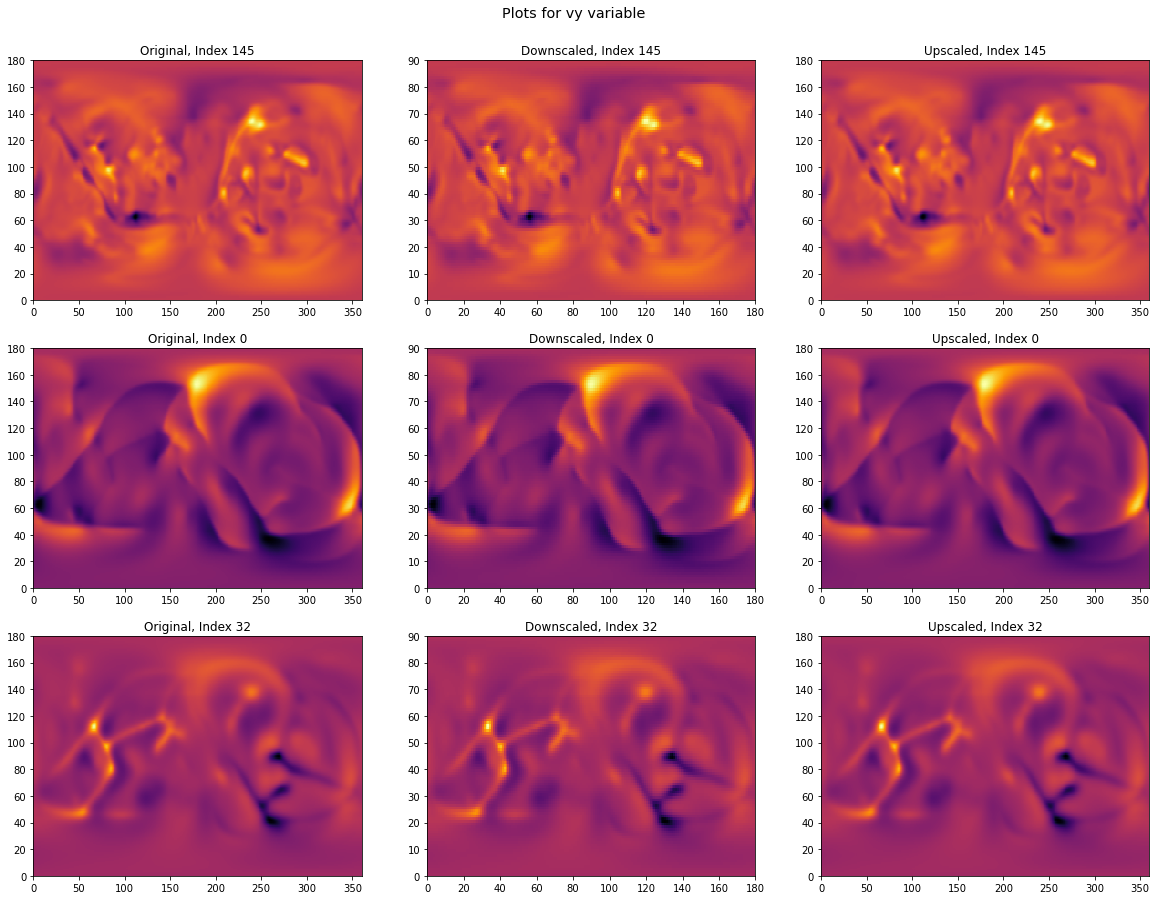

In [99]:
var_to_plot = var_list[2]
print(var_to_plot)
color_scheme='inferno'

        
title_list = ['Original', "Downscaled", "Upscaled"]*3
r_index_list = np.array([145, 0 ,32]*3).reshape((3,3)).flatten('F') # flatten array

# create image
fig, axes = plt.subplots(3,3, figsize=(20,15))

for ax, title, r_index in zip(axes.flat, title_list, r_index_list):
    
    # original data
    if title == 'Original':

        orig_data = data[var_to_plot][:,r_index,:].values
        ax.pcolormesh(orig_data, cmap=color_scheme)
        ax.set_title(f"{title}, Index {r_index}")
    
    # downscaled data
    if title == 'Downscaled':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                downscale_data = data_scaled_array[:,r_index,:,i]
                ax.pcolormesh(downscale_data, cmap=color_scheme)
                ax.set_title(f"{title}, Index {r_index}")


    # upscale data
    if title == 'Upscaled':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                upscale_data = data_upscaled_array[:,r_index,:,i]
                ax.pcolormesh(upscale_data, cmap=color_scheme)
                ax.set_title(f"{title}, Index {r_index}")

fig.suptitle(f'Plots for {var_to_plot} variable', y=0.93, fontsize='x-large')
# plt.savefig('comparison.jpg',format='jpg', dpi=600, bbox_inches = "tight")
plt.show()

In [100]:
data_scaled_array.dtype

dtype('float16')

In [101]:
data_upscaled_array.dtype

dtype('float32')

In [102]:
data_scaled_array.shape

(90, 201, 180, 8)

Save the `data_scaled_array` as a h5py file.

In [103]:
var_list

['temperature',
 'vx',
 'vy',
 'vz',
 'thermal conductivity',
 'thermal expansivity',
 'temperature anomaly',
 'spin transition-induced density anomaly']

In [104]:
import h5py
import pickle

In [105]:
# create a list of all the variables.
var_list = list(data.keys())
print(var_list)

['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


In [112]:
data.r.values[0:10]

array([3485.  , 3492.25, 3506.75, 3521.26, 3535.76, 3550.26, 3564.76,
       3579.27, 3593.77, 3608.27])

In [106]:
data_scaled_array.dtype

dtype('float16')

In [115]:
with h5py.File("data_scaled_array_50percent_01.hdf5", "w") as f:
    dset = f.create_dataset("data_scaled_array", data=data_scaled_array)
    
# with h5py.File("data_scaled_array_10percent_01.hdf5", "w") as f:
#     dset = f.create_dataset("data_scaled_array", data=data_scaled_array)
    
# save var_list as a pickle
with open('var_list.pkl', 'wb') as f:
    pickle.dump(var_list, f)
    
# save radius array as a pickle
with open('radius_array.pkl', 'wb') as f:
    pickle.dump(data.r.values, f)

In [116]:
# load back the file
with h5py.File("data_scaled_array_50percent_01.hdf5", "r") as f:
    test_array = f["data_scaled_array"][:].astype('float16')
    
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)

In [117]:
var_list

['temperature',
 'vx',
 'vy',
 'vz',
 'thermal conductivity',
 'thermal expansivity',
 'temperature anomaly',
 'spin transition-induced density anomaly']

In [118]:
test_array.dtype

dtype('float16')

In [119]:
# check to see that two arrays are the same
if np.array_equal(test_array[:,0,:,0,], data_scaled_array[:,0,:,0]):
    print('Images are the same')
else:
    print('Images are NOT the same!')

Images are the same


## Downscale to 15-25%
We want to see how small we can get the compressed file.
* Downscale to 15-25%
* Remove every 2nd, 3rd, or 4th radial layer
* Save as float16